# Apache Spark - Analyzing Food Insecurity in NYC using KeyFoods Price Catalogs

In this notebook, we study the food insecurity problem by looking at the listed prices of various food items across neighborhoods in NYC. Our hypothesis is that *people living in areas with higher food insecurity problems would pay more for the same items compared to those in more secured areas*. For the scope of work, we will only assess food products from KeyFoods supermarkets, one of the top 4 Supermarket Leaders in Metro New York (according [Food Trade News 2021 report](https://www.foodtradenews.com/2021/06/29/food-trade-news-2021-market-study-issue/)). In particular, we will use the following datasets:

### **`keyfood_products.csv`**

This CSV file contains the price information about 2 million food items listed on KeyFoods stores in NYC.

|store|department|upc|product|size|price|
|--|--|--|--|--|--|
102|bakery|102-28556000000|Store Prepared - Challah Egg|1 EA|\$4.99 each|
102|bakery|102-28781600000|Store Prepared - fw Cheesecake Plain 7 Inch|1 EA|\$27.99 each|
|...|...|...|...|...|...|

The details of the columns are as follows:

|Column|Description|
|--|--|
|**store** | The unique id of each store |
|**department**| The department (or aisle) that the food item belongs to. Possible values are:<br />`'bakery'`,`'beverages'`,`'breakfast'`,`'deli'`,`'frozen'`,`'international'`,<br/>`'meatandseafood'`,`'pantry'`,`'produce'`,`'refrigerated'`, and `'snacks'`|
|**upc**|The unique id for each item in a food store. It is often in the format of `SID-XXXXXXXXXX`,<br/> where `SID` is a store id if it's specific to a store, `UPC` if it's a general product, or `'KEY'` <br/> if it's a KeyFoodsproduct. If an item doesn't have any UPC code, this field will be `N/A`.|
|**product**|This is the listed name of the product|
|**size**|The unit that the product is being sold in|
|**price**|The price text of the product as shown on their websites. This is not a number but have<br/>been verified to start with the price mark`$XX.XX`. Note that for items without price<br/>information, this field could be listed as `Price not Available`|



This is the *big data* part of the homework, where we need to use Apache Spark to process it.



### **`keyfood_nyc_stores.json`**

This JSON file contains information for all KeyFoods stores in NYC. There are a lot of details about each store, however, for this homework, we are only interested in the following fields:

|Field|Description|
|--|--|
|**name** | This is the unique id of each store, which could be crosswalk with the **store** field above |
|**communityDistrict**|The community district code that the store belongs to. It's simply a larger geographical<br/> unit comparing to a zip code. More information can be found [here](https://communityprofiles.planning.nyc.gov/).|
|**foodInsecurity**|A food insecurity score computed for the community district that the stores belong to.<br/> This value has the range of 0 to 1 with 0 being without any food insecurity rish, and 1 <br/> has the most food insecure risk.|



### **`keyfood_sample_items.csv`**

This data contains the list of 22 food items that we would like to study initially to assess our hypothesis. For each item, we have the UPC code (which needs to be generalized across store) and the item name. Here is the list:

|UPC code|Item Name|
|--|--|
|SID-20308200000|Broccoli Crowns|
|KEY-000000004094|Fresh Produce - Carrot Bunch|
|KEY-000000004062|Fresh Produce - Cucumbers|
|SID-00000004072|Fresh Produce - Potatoes Russet|
|SID-00000004131|Fresh Produce - Apples Fuji Large|
|KEY-00000004013|Produce - Orange Navel 113|
|UPC-048500001004|Tropicana - Juice Orange Pure Prem Orig|
|UPC-017400108700|Carolina - Whole Grain Brown Rice|
|UPC-016000487697|General Mills - Cherrios Multi Grain Cereal|
|UPC-073296027686|Urban Meadow - 100 Whole Wheat Bread|
|UPC-048000013651|Chicken of the Sea - Solid Wht Albacore Tuna in Oil|
|SID-20115200000|Beef - Beef Semi Bnls Chuck Stk|
|SID-28080600000|Perdue - Split Chicken Breast Fam Pack|
|UPC-073296057461|Urban Meadow - Plain Low Fat Yogurt|
|UPC-041757021443|Laughing Cow - White Cheddar Wedges|
|UPC-073296069280|Urban Meadow - Large White Eggs|
|UPC-088365000347|Cream O Land - Gallon 2% Milk|
|UPC-072940744016|Redpack - Tomato Crushed|
|UPC-051500255162|Jif - Creamy Peanut Butter|
|UPC-073296025903|Urban Meadow - Canola Oil|
|UPC-041331124461|Goya - Beans Cannelini Can|
|UPC-014500001894|Birds Eye - Spinach Leaf|

where `SID` should be replaced with the store id.


### Notes

* There are 3 tasks below. You can use Google Colab for the first 2 tasks. Task 3 requires the use of NYU HPC.

* Our big data set (`keyfood_products.csv`) is assumed to be on HDFS, and must be accessed using Spark (either as RDD or DataFrame).

* You are not allowed to collect the raw data to the notebook and process them without using Spark. However, it is okay to collect intermediate data for processing. Just try to collect as little as possible.

## Environment Setup


In [ ]:
%%shell
gdown --quiet 1O1U_t-cpmValVK2mjdTzcFxIbGw05vOw
gdown --quiet 1YUBKrtNV3QUz1RutMnMbJdQj7rv-Lkd5
gdown --quiet 1f79oETtvN3NQLYPnVGhurE1UBDP4IQP-
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=8be8892da9aee71f7ae7350bcf6efee8e1633730549e84ae9a91abf77c47ace8
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import IPython
%matplotlib inline
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)
spark

<ipython-input-2-bd29a5ba4fde>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats('svg')


## Task 1 - Visualizing Distributions of Listed Food Prices

In the first task, we would like to see how the listed prices for food items vary across stores. For each item in the sample list provided in `keyfood_sample_items.csv`, we can simply overlay a [strip plot](https://seaborn.pydata.org/generated/seaborn.stripplot.html) with a [violin plot](https://seaborn.pydata.org/generated/seaborn.violinplot.html). In addition, to better correlate the price distribution with the food insecurity risk, we will color the markers by the percentage of food insecurity (derived from the `foodInsecurity` field in `keyfood_nyc_stores.json`). An expected visualization is provided below:

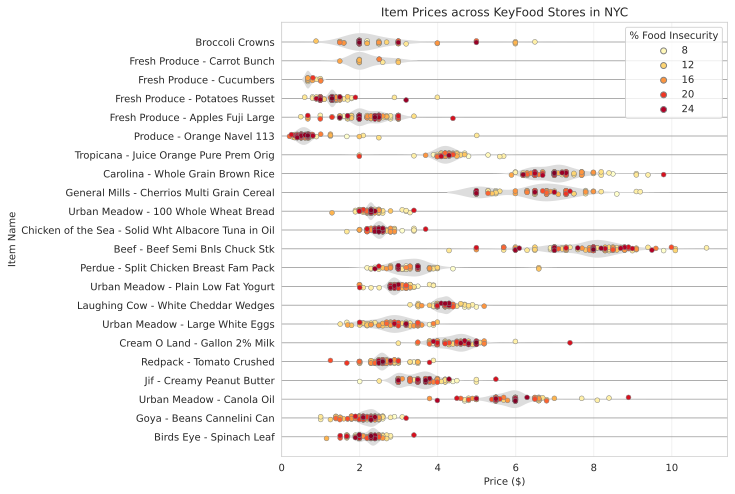

In [ ]:
#@title

To produce the plot, we need to following data, where each row represents a listing of the sample food item from a store.

| Item Name	| Price ($) | % Food Insecurity |
|--|--|--|
|Urban Meadow - 100 Whole Wheat Bread | 2.29 | 11 |
|General Mills - Cherrios Multi Grain Cereal | 6.79 | 11 |
|Birds Eye - Spinach Leaf | 2.29 | 11 |
|Beef - Beef Semi Bnls Chuck Stk | 7.99 | 11 |
|Chicken of the Sea - Solid Wht Albacore Tuna in Oil | 2.49 | 11 |
| ... | ... | ... |

Your task is to compute the above table from the input data.

### INPUT
**You must read `keyfood_products.csv` into a Spark's DataFrame or Spark's RDD**, and process the data from there. You may assume the other two files (`keyfood_nyc_stores.json` and `keyfood_sample_items.csv`) are stored locally with your driver code.


### OUTPUT
Your output must be stored in another Spark's DataFrame or Spark's RDD, and being named as `outputTask1` at the end of the task. The column order must be the same as above (item name, price, and then % food insecurity). If your output is an RDD, each record should be a tuple of 3 elements. If your output is a Spark's DataFrame, it must have exactly 3 columns (you name them anything but they must in the same order).


### [TODO] A. Complete your code

Using either Spark's RDD or Spark's DataFrame transformations. The output must be placed in the `outputTask1` variable:

* Items must be filtered by UPC codes and names provided in the `keyfood_sample_items.csv`. UPC codes are considered equal if their numeric parts (the second portion after the `-`) are the same. For example, `SID-20308200000` is the same as `102-20308200000`, `KEY-20308200000`, etc.

* `Item Name` must be taken the sample items when there's a UPC code match (as defined above).

* `Price` should be extracted from the `price` column of `keyfood_products.csv`. The prefix `$` should be removed, and the output price should be converted to a float number (i.e. not a string).

*  `% Food Insecurity` is simply the percentage of the `foodInsecurity` score, i.e. by multiplying `foodInsecruity` by `100`.


In [ ]:
# Read keyfood_sample_items.csv into a Pandas DataFrame
df = pd.read_csv("keyfood_sample_items.csv")

# Convert Pandas DataFrame to Spark RDD
sample_rdd = spark.sparkContext.parallelize(df.values.tolist()) \
                  .map(lambda row: (row[0].split("-")[1], row[1]))

# Display the first 5 rows of the
print(sample_rdd.count())
sample_rdd.take(5)

22


[('20308200000', 'Broccoli Crowns'),
 ('000000004094', 'Fresh Produce - Carrot Bunch'),
 ('000000004062', 'Fresh Produce - Cucumbers'),
 ('00000004072', 'Fresh Produce - Potatoes Russet'),
 ('00000004131', 'Fresh Produce - Apples Fuji Large')]

In [ ]:
keyfood = "keyfood_products.csv"
keyfood_rdd = sc.textFile(keyfood, use_unicode=True).cache()
list(enumerate(keyfood_rdd.first().split(',')))

[(0, 'store'),
 (1, 'department'),
 (2, 'upc'),
 (3, 'product'),
 (4, 'size'),
 (5, 'price')]

In [ ]:
def extractFeatures(partId, rows):
    if partId == 0:
        next(rows) # avoiding header here
    reader = csv.reader(rows)
    for fields in reader:
        store, upc, price = fields[0], fields[2], fields[5]
        if upc != "N/A":
            upc = upc.split("-")[1]
        else:
            continue
        price_parts = price.split("\xa0")
        price = price_parts[0].replace("$", "")
        yield (upc, (store, price))

keyfood_rdd = keyfood_rdd.mapPartitionsWithIndex(extractFeatures)
print(keyfood_rdd.count())
keyfood_rdd.take(5)

2234912


[('28556000000', ('102', '4.99')),
 ('28781600000', ('102', '27.99')),
 ('00000000099', ('102', '1.50')),
 ('00000000191', ('102', '5.49')),
 ('22794900000', ('102', '7.99'))]

In [ ]:
#Joining two rdd
dfA = sample_rdd.join(keyfood_rdd) \
                .map(lambda x: (x[1][1][0], (x[0], (x[1][1][1], x[1][0]))))

print(dfA.count())
dfA.take(5)

3116


[('102', ('00000004131', ('1.99', 'Fresh Produce - Apples Fuji Large'))),
 ('103', ('00000004131', ('1.99', 'Fresh Produce - Apples Fuji Large'))),
 ('434', ('00000004131', ('2.59', 'Fresh Produce - Apples Fuji Large'))),
 ('564', ('00000004131', ('2.49', 'Fresh Produce - Apples Fuji Large'))),
 ('566', ('00000004131', ('2.49', 'Fresh Produce - Apples Fuji Large')))]

In [ ]:
# load JSON file into a pandas DataFrame
df = pd.read_json('keyfood_nyc_stores.json')
df2 = df.transpose()
df3= df2.reset_index(level=0, inplace=False)
stores_df= df3 [['name','communityDistrict','foodInsecurity']]

In [ ]:
# Create a Spark DataFrame from the Pandas DataFrame
stores_rdd = spark.createDataFrame(stores_df).rdd

# Transform the RDD to the desired format
stores_rdd2 = stores_rdd.map(lambda x: (x[0], (x[1], x[2]*100)))

# Print the output
stores_rdd2.take(5)

[('1920', ('302', 13.390474668159902)),
 ('1918', ('308', 16.9051320723646)),
 ('1436', ('103', 17.9323946238924)),
 ('2314', ('308', 16.9051320723646)),
 ('1830', ('308', 16.9051320723646))]

In [ ]:
dfC = dfA.join(stores_rdd2)
dfC.take(5)

[('778',
  (('00000004131', ('2.99', 'Fresh Produce - Apples Fuji Large')),
   ('413', 8.9203113282698))),
 ('778',
  (('051500255162', ('2.99', 'Jif - Creamy Peanut Butter')),
   ('413', 8.9203113282698))),
 ('778',
  (('073296025903', ('5.49', 'Urban Meadow - Canola Oil')),
   ('413', 8.9203113282698))),
 ('778',
  (('048500001004', ('4.09', 'Tropicana - Juice Orange Pure Prem Orig')),
   ('413', 8.9203113282698))),
 ('778',
  (('073296027686', ('2.29', 'Urban Meadow - 100 Whole Wheat Bread')),
   ('413', 8.9203113282698)))]

In [ ]:
dfF = dfC.map(lambda x: (x[1][0][1][1], x[1][0][1][0], x[1][1][1]))
dfF.take(5)

[('Fresh Produce - Apples Fuji Large', '2.99', 8.9203113282698),
 ('Jif - Creamy Peanut Butter', '2.99', 8.9203113282698),
 ('Urban Meadow - Canola Oil', '5.49', 8.9203113282698),
 ('Tropicana - Juice Orange Pure Prem Orig', '4.09', 8.9203113282698),
 ('Urban Meadow - 100 Whole Wheat Bread', '2.29', 8.9203113282698)]

In [ ]:
outputTask1 = dfF.map(lambda x: (x[0], pd.to_numeric(x[1]), int(x[2])))
outputTask1.take(5)

[('Fresh Produce - Apples Fuji Large', 2.99, 8),
 ('Jif - Creamy Peanut Butter', 2.99, 8),
 ('Urban Meadow - Canola Oil', 5.49, 8),
 ('Tropicana - Juice Orange Pure Prem Orig', 4.09, 8),
 ('Urban Meadow - 100 Whole Wheat Bread', 2.29, 8)]

In [ ]:
## DO NOT EDIT BELOW
outputTask1 = outputTask1.cache()
outputTask1.count()

3116

### B. Run to validate your output

In [ ]:
#@title
def dfTask1(data):
    rdd = data.rdd if hasattr(data, 'rdd') else data
    if rdd.count()>10000:
        raise Exception('`outputTask1` has too many rows')
    rows = map(lambda x: (x[0], x[1], int(x[2])), rdd.collect())
    return pd.DataFrame(data=rows, columns=['Item Name','Price ($)','% Food Insecurity'])

def plotTask1(data, figsize=(8,8)):
    itemNames = pd.read_csv('keyfood_sample_items.csv')['Item Name']
    itemKey = dict(map(reversed,enumerate(itemNames)))
    df = dfTask1(data).sort_values(
        by = ['Item Name', '% Food Insecurity'],
        key = lambda x: list(map(lambda y: itemKey.get(y,y), x)))
    plt.figure(figsize=figsize)
    ax = sns.violinplot(x="Price ($)", y="Item Name", data=df, linewidth=0,
                        color='#ddd', scale='width', width=0.95)
    idx = len(ax.collections)
    sns.scatterplot(x="Price ($)", y="Item Name", hue='% Food Insecurity', data=df,
                    s=24, linewidth=0.5, edgecolor='gray', palette='YlOrRd')
    for h in ax.legend_.legendHandles:
        h.set_edgecolor('gray')
    pts = ax.collections[idx]
    pts.set_offsets(pts.get_offsets() + np.c_[np.zeros(len(df)),
                                            np.random.uniform(-.1, .1, len(df))])
    ax.set_xlim(left=0)
    ax.xaxis.grid(color='#eee')
    ax.yaxis.grid(color='#999')
    ax.set_title('Item Prices across KeyFood Stores in NYC')
    return ax

if 'outputTask1' not in locals():
    raise Exception('There is no `outputTask1` produced in Task 1.A')

plotTask1(outputTask1);

<ipython-input-57-95592f60a498>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


## Task 2 - Finding the Highest Priced Items in Areas with Food Insecurity

Examining the plot from Task 1, we could notice many cases where product prices are higher in areas with high food insecurity. For example, the highest priced *Cream O Land - Gallon 2% Milk* is in the area with a high `% Food Insecurity` value (the right most marker has a saturated red, approximately 20%). This suggests that our hypothesis might hold. At this point, we could perform a full *Null Hypothesis Test*, but before that, we would like to expand our study beyond just the sample items.

In particular, we would like to find all products that meets all of the conditions below:

1.  Must be sold in at least 3 stores, each with a food insecurity risk of `low`, `medium`, and `high`, respectively. The risk is based on the `foodInsecurity` value of each store, and computed as follows:

|foodInsecurity|Risk Rating|
|--|--|
|<=0.09|low|
|>0.09 and <=0.13| n/a|
|>0.13 and <=0.16| medium|
|>0.16 and <=0.23| n/a|
|>0.23| high|

2. The highest priced location has the risk rating of `high`.

3. The standard deviation of the product prices must be more than `$1`, i.e. when we collect all listed prices of the product based on its UPC, and compute the standard deviation, its value should be larger than `1`.

Your task is to find the list of all UPC codes (only the second part after the `-` in `SID-XXXXXXXXXXX`) that meet such conditions along with its `department` value.

### INPUT
**You must read `keyfood_products.csv` into a Spark's DataFrame or Spark's RDD**, and process the data from there. You may assume `keyfood_nyc_stores.json` is stored locally with your driver code.

### OUTPUT
Your output must be stored in another Spark's DataFrame or Spark's RDD, and being named as `outputTask2` at the end of the task.



### [TODO] A. Complete your code

Using either Spark's RDD or Spark's DataFrame transformations. The output must be placed in the `outputTask2` variable with the following column order:

| Extracted UPC Code | Item Name | Department |
|--|--|--|
|073296027686 | Urban Meadow - 100 Whole Wheat Bread | refrigerated |
|20308200000 | Broccoli Crowns | produce |
| ... | ... | ... |

* The data must be sorted by the **Extracted UPC Code** alphabetically (i.e. as strings and not as numbers).

* **Item Name** can be taken from any of the product instance.

*NOTE*: the output below is based on using Python's unbiased standard deviation (`statistics.stdev`). If you're using `statistics.pstdev`, you would see an answer of 94.

In [ ]:
keyfood = "keyfood_products.csv"
keyfood_rdd = sc.textFile(keyfood, use_unicode=True).cache()
def extractFeatures2(partId, rows):
    if partId == 0:
        next(rows) # avoiding header here
    reader = csv.reader(rows)
    for fields in reader:
        store, department, upc, price,name = fields[0], fields[1], fields[2], fields[5],fields[3]
        if upc != "N/A":
            upc = upc.split("-")[1]
        else:
            continue
        price_parts = price.split("\xa0")
        price = price_parts[0].replace("$", "")
        yield (upc, store,name, department, float(price))

keyfood_rdd2 = keyfood_rdd.mapPartitionsWithIndex(extractFeatures2).cache()
print(keyfood_rdd2.count())
keyfood_rdd2.take(5)

2234912


[('28556000000', '102', 'Store Prepared - Challah Egg', 'bakery', 4.99),
 ('28781600000',
  '102',
  'Store Prepared - fw Cheesecake Plain 7 Inch',
  'bakery',
  27.99),
 ('00000000099', '102', 'Croissant - Pretzel', 'bakery', 1.5),
 ('00000000191', '102', "Bakery ea Local Plu's", 'bakery', 5.49),
 ('22794900000', '102', 'Store Prepared - Dark Chocolate Cut', 'bakery', 7.99)]

In [ ]:
#Convert keyfood_rdd2 to a Spark DataFrame
keyfood_df = keyfood_rdd2.toDF(["UPC", "Store","ItemName", "Department", "Price"])
print(keyfood_df.count())
keyfood_df.show(5)

2234912
+-----------+-----+--------------------+----------+-----+
|        UPC|Store|            ItemName|Department|Price|
+-----------+-----+--------------------+----------+-----+
|28556000000|  102|Store Prepared - ...|    bakery| 4.99|
|28781600000|  102|Store Prepared - ...|    bakery|27.99|
|00000000099|  102| Croissant - Pretzel|    bakery|  1.5|
|00000000191|  102|Bakery ea Local P...|    bakery| 5.49|
|22794900000|  102|Store Prepared - ...|    bakery| 7.99|
+-----------+-----+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
# load JSON file into a pandas DataFrame
df = pd.read_json('keyfood_nyc_stores.json')
df2 = df.transpose()
df3= df2.reset_index(level=0, inplace=False)
stores_df= df3 [['name','foodInsecurity']]

In [ ]:
# Create a Spark DataFrame from the Pandas DataFrame
stores_df1 = spark.createDataFrame(stores_df) \
                   .withColumnRenamed("name", "Store")
stores_df1.show(5)

+-----+-------------------+
|Store|     foodInsecurity|
+-----+-------------------+
| 1920|0.13390474668159902|
| 1918|  0.169051320723646|
| 1436|  0.179323946238924|
| 2314|  0.169051320723646|
| 1830|  0.169051320723646|
+-----+-------------------+
only showing top 5 rows



In [ ]:
# Join the two dataframes on the Store column
joined_df1 = keyfood_df.join(stores_df1, "Store")

# Show the first five rows of the joined dataframe
joined_df1.count()

2234912

In [ ]:
from pyspark.sql.functions import when, col, collect_list

# Join the dataframes and compute the risk column using when function
joined_df1 = keyfood_df.join(stores_df1, "Store") \
                     .withColumn("Risk",
                                 when(col("foodInsecurity") <= 0.09, "low") \
                                 .when((col("foodInsecurity") > 0.09) & (col("foodInsecurity") <= 0.13), "n/a") \
                                 .when((col("foodInsecurity") > 0.13) & (col("foodInsecurity") <= 0.16), "medium") \
                                 .when((col("foodInsecurity") > 0.16) & (col("foodInsecurity") <= 0.23), "n/a") \
                                 .when(col("foodInsecurity") > 0.23, "high") \
                                 .otherwise("unknown"))
print(joined_df1.count())
joined_df1.show(5)

2234912
+-----+------------+--------------------+----------+-----+-------------------+----+
|Store|         UPC|            ItemName|Department|Price|     foodInsecurity|Risk|
+-----+------------+--------------------+----------+-----+-------------------+----+
| 1280| 00000000020|Bread - Pain Sici...|    bakery|  3.0|0.20698365892154502| n/a|
| 1280| 00000000027|      Bread - Saloio|    bakery| 0.79|0.20698365892154502| n/a|
| 1280| 00000000026|Bread - Salito's ...|    bakery|  0.6|0.20698365892154502| n/a|
| 1280| 00000000028|Bread - Saloio Co...|    bakery|  0.5|0.20698365892154502| n/a|
| 1280|014233109621|   Rye Bread W/ Flax|    bakery| 2.79|0.20698365892154502| n/a|
+-----+------------+--------------------+----------+-----+-------------------+----+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import collect_set, array_contains, size

# Group the joined dataframe by UPC and collect all Risk Rating values into a set
grouped_df = joined_df1.groupBy("UPC").agg(collect_set("Risk").alias("Risk"))

# Filter for the groups that contain all three ratings and count the number of ratings
counts_df = grouped_df.filter((array_contains("Risk", "low")) &
                              (array_contains("Risk", "medium")) &
                              (array_contains("Risk", "high"))) \
                      .withColumn("count", size("Risk")) \
                      .select("UPC", "count")
print(counts_df.count())
counts_df.show(5)

21505
+------------+-----+
|         UPC|count|
+------------+-----+
| 00000000003|    4|
| 00000000005|    4|
| 00000000006|    4|
| 00000000200|    4|
|000000003126|    4|
+------------+-----+
only showing top 5 rows



In [ ]:
# Join with joined_df1 to get the full information about each product
final_df = joined_df1.join(counts_df, "UPC")

# Show the first ten rows of the final dataframe
print(final_df.count())
final_df.show(10)

1701037
+-----------+-----+--------+----------+-----+-------------------+------+-----+
|        UPC|Store|ItemName|Department|Price|     foodInsecurity|  Risk|count|
+-----------+-----+--------+----------+-----+-------------------+------+-----+
|00000000003| 1370|Baguette|    bakery|  0.5|  0.180617780806476|   n/a|    4|
|00000000003|  778|Baguette|    bakery| 0.99|  0.089203113282698|   low|    4|
|00000000003|  600|Baguette|    bakery|  1.5|0.16848772763262101|   n/a|    4|
|00000000003| 1154|Baguette|    bakery|  1.5|0.13013947844995902|medium|    4|
|00000000003| 1310|Baguette|    bakery| 0.69|0.10841354662652501|   n/a|    4|
|00000000003| 1472|Baguette|    bakery| 0.05|  0.131135666871214|medium|    4|
|00000000003| 1770|Baguette|    bakery| 8.79|  0.141749970882059|medium|    4|
|00000000003| 1784|Baguette|    bakery| 3.99|0.09247806857985501|   n/a|    4|
|00000000003| 2156|Baguette|    bakery| 0.79|  0.246326333969826|  high|    4|
|00000000003| 1866|Baguette|    bakery| 2.99

In [ ]:
from pyspark.sql.functions import max, stddev_samp

# Group final_df by UPC and Risk Rating, and find the max price for each group
max_prices_df = final_df.groupBy("UPC", "Risk").agg(max("Price").alias("Max Price"))
print(max_prices_df.count())
max_prices_df.show(5)

86002
+-----------+------+---------+
|        UPC|  Risk|Max Price|
+-----------+------+---------+
|00000000003|   n/a|     3.99|
|00000000003|   low|     0.99|
|00000000003|medium|     8.79|
|00000000003|  high|    14.99|
|00000000005|   low|     1.29|
+-----------+------+---------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import max, stddev_samp
from pyspark.sql.window import Window
from pyspark.sql.functions import col

# Group final_df by UPC and Risk Rating, and find the max price for each group
window = Window.partitionBy("UPC")
max_prices_df = final_df.groupBy("UPC").agg(max("Price").alias("Max Price"))

# Filter out the rows where the high risk store does not have the highest price
filtered_df = final_df.join(max_prices_df, "UPC") \
                      .filter((col("Risk") == "high") & (col("Price") == col("Max Price"))) \
                      .select(col("UPC"),col("Store"),col("Department"),col("Price"),col("foodInsecurity"),col("Risk"),col("ItemName"))

# Show the first ten rows of the filtered dataframe
print(filtered_df.count())
filtered_df.show(10)

578
+------------+-----+------------+-----+-----------------+----+--------------------+
|         UPC|Store|  Department|Price|   foodInsecurity|Risk|            ItemName|
+------------+-----+------------+-----+-----------------+----+--------------------+
|042400039358| 2136|   breakfast| 5.49|0.266888708317204|high|Malt-o-meal - Fru...|
|076301241220| 1766|   beverages| 3.99|0.251325606228962|high|Apple & Eve - Frt...|
|079893408590| 1774|     produce| 3.99|0.246326333969826|high|Dole - Organic Ce...|
|076114380109| 1456|      pantry| 3.29|0.255057334738635|high|Spice Supreme Garlic|
|852810489120| 2182|refrigerated| 5.99|0.255057334738635|high|Land O Lakes - Ca...|
|011115224274| 1456|refrigerated| 5.99|0.255057334738635|high|Imperial - Spread...|
|011233084507| 2538|      bakery| 4.19|0.251325606228962|high|Table Talk - Swee...|
|073296061109| 1456|refrigerated| 4.79|0.255057334738635|high|Urban Meadow - Mu...|
|699058801242| 2182|     produce| 5.99|0.255057334738635|high|Fresh Prod

In [ ]:
final_df2 = final_df.alias('f1') \
                    .join(filtered_df.alias('f2'),col("f1.UPC") == col("f2.UPC"), 'inner') \
                    .select(col("f1.UPC"),col("f1.Store"),col("f1.Department"),col("f1.Price"),col("f1.Risk"),col("f1.ItemName"))


In [ ]:
# Compute the standard deviation of the product prices for each UPC
stddev_df = final_df2.groupBy("UPC").agg(stddev_samp("Price").alias("stddev")) \
                                   .filter(col("stddev") > 1)
print(stddev_df.count())
stddev_df.show(5)

96
+-----------+------------------+
|        UPC|            stddev|
+-----------+------------------+
|00000000003| 4.045788757049318|
|00000000200|17.854172994942484|
|00000004080|1.1605714943383918|
|00000004109|1.0102504939895156|
|00000004220| 3.087550269496299|
+-----------+------------------+
only showing top 5 rows



In [ ]:
# Join the dataframes together
result_df = final_df2.join(stddev_df, "UPC")
print(result_df.count())
result_df.show(5)

3351
+-----------+-----+----------+-----+------+--------+-----------------+
|        UPC|Store|Department|Price|  Risk|ItemName|           stddev|
+-----------+-----+----------+-----+------+--------+-----------------+
|00000000003| 1370|    bakery|  0.5|   n/a|Baguette|4.045788757049318|
|00000000003|  778|    bakery| 0.99|   low|Baguette|4.045788757049318|
|00000000003|  600|    bakery|  1.5|   n/a|Baguette|4.045788757049318|
|00000000003| 1154|    bakery|  1.5|medium|Baguette|4.045788757049318|
|00000000003| 1310|    bakery| 0.69|   n/a|Baguette|4.045788757049318|
+-----------+-----+----------+-----+------+--------+-----------------+
only showing top 5 rows



In [ ]:
outputTask2 = result_df.dropDuplicates(subset=['UPC'])

In [ ]:
outputTask2 = outputTask2.select("UPC", "ItemName", "Department").sort("UPC")
outputTask2.show(5)

+-----------+--------------------+----------+
|        UPC|            ItemName|Department|
+-----------+--------------------+----------+
|00000000003|            Baguette|    bakery|
|00000000200|Bakery ea Local P...|    bakery|
|00000004034|Fresh Produce - H...|   produce|
|00000004080|Way Better - Aspa...|   produce|
|00000004109|Quickie - Apple C...|   produce|
+-----------+--------------------+----------+
only showing top 5 rows



In [ ]:
## DO NOT EDIT BELOW
outputTask2 = outputTask2.cache()
outputTask2.count()

96

### B. Run to validate your output

In [ ]:
#@title
def dfTask2(data):
    rdd = data.rdd if hasattr(data, 'rdd') else data
    if rdd.count()>1000:
        raise Exception('`outputTask2` has too many rows')
    return pd.DataFrame(data=rdd.collect(),
                        columns=['Extracted UPC Code','ItemName','Department'])

if 'outputTask2' not in locals():
    raise Exception('There is no `outputTask2` produced in Task 2')

dfTask2(outputTask2).groupby('Department').size()

Department
bakery             4
beverages          2
breakfast          1
deli               4
frozen            12
meatandseafood     7
pantry            20
produce           40
refrigerated       3
snacks             3
dtype: int64

## Task 3 - Run on DataProc

You are asked to convert your Task 1 into a single `.py` file named `BDM_HW4_EMPLID_LastName.py` that can be executed on any DataProc cluster. Your file will be run with the following command:

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster bdma --files keyfood_nyc_stores.json,keyfood_sample_items.csv \
--properties=spark.hadoop.fs.gs.requester.pays.mode=AUTO,spark.hadoop.fs.gs.requester.pays.project.id=YOUR_PROJECT_ID \
BDM_HW4_EMPLID_LastName.py -- OUTPUT_FOLDER_NAME

As part of the test, you must be able to run your code and output to the class shared folder, i.e.: `gs://bdma/shared/2023_spring/HW4/EMPLID_LastName`, **replacing `EMPLID` and `LastName` with yours**.

Note that, if you run your code multiple times, make sure to only run your working version when output to the shared folder, or you must remove the existing output to run your code again.

Notes:
* `YOUR_PROJECT_ID`: should be your project ID
* `OUTPUT_FOLDER_NAME`: being specified by the user at run-time. You can access this variable through `sys.argv[1]` in your code. Your code must output data into this folder (e.g. through `saveAsTextFile`).
* You may assume that both `keyfood_nyc_stores.json` and `keyfood_sample_items.csv` are in the current folder of the evaluation environment (or in yours). For testing purposes you may download the files into your code folder using the `gdown` command at the top of the notebook.
* `keyfood_products.csv` is expected to be on HDFS at `gs://bdma/data/keyfood_products.csv `, you can use this path directly with Spark.

Alternatively, to make it easier, you could write your configurations to a file and pass to the command line. For example, running the following two cells (still need to replace the script name, `YOUR_PROJECT_ID` and `OUTPUT_FOLDER_NAME` with appropriate values) would be equivalent to the command above:

In [ ]:
!pip install google-cloud-dataproc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.5/307.5 kB 16.4 MB/s eta 0:00:00


In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=TCSkRdmrWy0PhkL1QiHrTNHRxZEmnG&prompt=consent&access_type=offline&code_challenge=y0YaNl7tMpB6_WRd2xv9pp1siNpBO_eNF5rw1d1cxik&code_challenge_method=S256

Enter authorization code: 4/0AbUR2VOSCD86X29VE6tTBOI3QQUwciIs0cJKButA3FE8eToaqciMZmRCJGT3Vb9kabD6OQ

You are now logged in as [sumaiyauddin1995@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_I

In [ ]:
!gcloud projects list

PROJECT_ID             NAME              PROJECT_NUMBER
big-data-380022        big data          901723776519
rich-suprstate-380020  My First Project  72957410723


In [ ]:
!gcloud config set project big-data-380022
!gcloud config set compute/region us-west1
!gcloud config set compute/zone us-west1-a
!gcloud config set dataproc/region us-west1

Updated property [core/project].
Updated property [compute/region].
Updated property [compute/zone].
Updated property [dataproc/region].


In [ ]:
%%writefile props.conf
spark.hadoop.fs.gs.requester.pays.mode=AUTO
spark.hadoop.fs.gs.requester.pays.project.id=big-data-380022

Writing props.conf


In [ ]:
!gcloud dataproc clusters create bdma --enable-component-gateway --region us-west1 --zone us-west1-a --master-machine-type n1-standard-4 --master-boot-disk-size 500 --num-workers 2 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 2.0-debian10 --project big-data-380022

Waiting on operation [projects/big-data-380022/regions/us-west1/operations/2fac7c40-0896-3879-b5b3-a1a7be4f6a0d].

Created [https://dataproc.googleapis.com/v1/projects/big-data-380022/regions/us-west1/clusters/bdma] Cluster placed in zone [us-west1-a].


In [ ]:
!gcloud dataproc clusters list

NAME  PLATFORM  WORKER_COUNT  PREEMPTIBLE_WORKER_COUNT  STATUS   ZONE        SCHEDULED_DELETE
bdma  GCE       2                                       RUNNING  us-west1-a


In [ ]:
!gcloud dataproc clusters describe bdma

clusterName: bdma
clusterUuid: 710d7080-fbd1-4fa1-bc78-7aa661838bfc
config:
  configBucket: dataproc-staging-us-west1-901723776519-ddnkwogk
  endpointConfig:
    enableHttpPortAccess: true
    httpPorts:
      HDFS NameNode: https://6xpn24fmyffp7pnhhhykrexg34-dot-us-west1.dataproc.googleusercontent.com/hdfs/dfshealth.html
      HiveServer2 (bdma-m): https://6xpn24fmyffp7pnhhhykrexg34-dot-us-west1.dataproc.googleusercontent.com/hiveserver2ui/bdma-m?host=bdma-m
      MapReduce Job History: https://6xpn24fmyffp7pnhhhykrexg34-dot-us-west1.dataproc.googleusercontent.com/jobhistory/
      Spark History Server: https://6xpn24fmyffp7pnhhhykrexg34-dot-us-west1.dataproc.googleusercontent.com/sparkhistory/
      Tez: https://6xpn24fmyffp7pnhhhykrexg34-dot-us-west1.dataproc.googleusercontent.com/apphistory/tez-ui/
      YARN Application Timeline: https://6xpn24fmyffp7pnhhhykrexg34-dot-us-west1.dataproc.googleusercontent.com/apphistory/
      YARN ResourceManager: https://6xpn24fmyffp7pnhhhykrexg34

In [ ]:
%%writefile BDM_HW4_24373710_Uddin.py
#!/usr/bin/python

import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import IPython
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")
import sys

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)
spark


# Read keyfood_sample_items.csv into a Pandas DataFrame
df = pd.read_csv("keyfood_sample_items.csv")

# Convert Pandas DataFrame to Spark RDD
sample_rdd = spark.sparkContext.parallelize(df.values.tolist()) \
                  .map(lambda row: (row[0].split("-")[1], row[1]))

keyfood = 'gs://bdma/data/keyfood_products.csv'
keyfood_rdd = sc.textFile(keyfood, use_unicode=True).cache()
list(enumerate(keyfood_rdd.first().split(',')))
def extractFeatures(partId, rows):
    if partId == 0:
        next(rows) # avoiding header here
    reader = csv.reader(rows)
    for fields in reader:
        store, upc, price = fields[0], fields[2], fields[5]
        if upc != "N/A":
            upc = upc.split("-")[1]
        else:
            continue
        price_parts = price.split("\xa0")
        price = price_parts[0].replace("$", "")
        yield (upc, (store, price))

keyfood_rdd = keyfood_rdd.mapPartitionsWithIndex(extractFeatures)
dfA = sample_rdd.join(keyfood_rdd) \
                .map(lambda x: (x[1][1][0], (x[0], (x[1][1][1], x[1][0]))))

# load JSON file into a pandas DataFrame
df = pd.read_json('keyfood_nyc_stores.json')
df2 = df.transpose()
df3= df2.reset_index(level=0, inplace=False)
stores_df= df3 [['name','communityDistrict','foodInsecurity']]
# Create a Spark DataFrame from the Pandas DataFrame
stores_rdd = spark.createDataFrame(stores_df).rdd

# Transform the RDD to the desired format
stores_rdd2 = stores_rdd.map(lambda x: (x[0], (x[1], x[2]*100)))
dfC = dfA.join(stores_rdd2)
dfF = dfC.map(lambda x: (x[1][0][1][1], x[1][0][1][0], x[1][1][1]))
outputTask1 = dfF.map(lambda x: (x[0], pd.to_numeric(x[1]), int(x[2]))).cache()
print(outputTask1.count())

filepath = sys.argv[1]

outputTask1.saveAsTextFile(filepath)

Overwriting BDM_HW4_24373710_Uddin.py


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster bdma --files keyfood_nyc_stores.json,keyfood_sample_items.csv \
--properties-file=props.conf BDM_HW4_24373710_Uddin.py -- gs://bdma/shared/2023_spring/HW4/24373710_Uddin

Job [c93015345f09451aa9e9b0ccd7272352] submitted.
Waiting for job output...
/tmp/c93015345f09451aa9e9b0ccd7272352/BDM_HW4_24373710_Uddin.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats('svg')
23/05/03 05:21:10 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/03 05:21:10 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/03 05:21:10 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/03 05:21:11 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/03 05:21:11 INFO org.sparkproject.jetty.util.log: Logging initialized @7371ms to org.sparkproject.jetty.util.log.Slf4jLog
23/05/03 05:21:11 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_362-b09
23/05/03 

In [ ]:
!gsutil -u big-data-380022 ls gs://bdma/shared/2023_spring/HW4

gs://bdma/shared/2023_spring/HW4/14211712_Salas/
gs://bdma/shared/2023_spring/HW4/15304719_Graig/
gs://bdma/shared/2023_spring/HW4/16141003_Olsen/
gs://bdma/shared/2023_spring/HW4/23621671_Kannam/
gs://bdma/shared/2023_spring/HW4/23668189_Matuszewski/
gs://bdma/shared/2023_spring/HW4/23703839_Feng/
gs://bdma/shared/2023_spring/HW4/23735863_Ghimire/
gs://bdma/shared/2023_spring/HW4/24363838_Lau/
gs://bdma/shared/2023_spring/HW4/24369480_Chandani/
gs://bdma/shared/2023_spring/HW4/24369705_Khandale/
gs://bdma/shared/2023_spring/HW4/24369977_Gulve/
gs://bdma/shared/2023_spring/HW4/24373710_Uddin/
gs://bdma/shared/2023_spring/HW4/24379388_Quadri/
gs://bdma/shared/2023_spring/HW4/24379541_Desai/
gs://bdma/shared/2023_spring/HW4/24438996_Radaelli/


In [ ]:
# !gsutil -u big-data-380022 cat gs://bdma/shared/2023_spring/HW4/24373710_Uddin/part*

In [ ]:
# !gsutil -u big-data-380022 rm -r gs://bdma/shared/2023_spring/HW4/EMPLID_LastName/

# IMPORTANT: DELETE YOUR CLUSTER AFTER DONE

In [ ]:
!gcloud dataproc clusters delete bdma -q
!gcloud dataproc clusters list

ERROR: (gcloud.dataproc.clusters.delete) Error parsing [cluster].
The [cluster] resource is not properly specified.
Failed to find attribute [project]. The attribute can be set in the following ways: 
- provide the argument `--project` on the command line
- set the property `core/project`
ERROR: (gcloud.dataproc.clusters.list) The required property [project] is not currently set.
It can be set on a per-command basis by re-running your command with the [--project] flag.

You may set it for your current workspace by running:

  $ gcloud config set project VALUE

or it can be set temporarily by the environment variable [CLOUDSDK_CORE_PROJECT]
